# ESG stock performance : an empirical study

## Importing libraries

In [356]:
import pandas as pd
import random
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as sco
import plotly.express as px

## Reading data

In [357]:
esg=pd.read_excel(r'C:\Users\niroo\Desktop\Jupyter\Projets\Ethique\ESG.xlsx')
dataset=pd.read_excel(r'C:\Users\niroo\Desktop\Jupyter\Projets\Ethique\S&P500.xlsx',index_col=0)

## Class creation

### ESG filter class creation

In [280]:
class ESG_filter:
    
    def __init__(self,esg_data):
        self.esg_data=esg_data
        
    def plot_sectors(self):
        stats = self.esg_data.groupby(by='Sector', as_index=False).mean()
        stats=stats.sort_values('ESG score',ascending=False)
        average = stats['ESG score'].mean(numeric_only=None)
        colors = ['mediumspringgreen' if (stat > average) else 'darkcyan' for stat in stats['ESG score']]
        plt.figure(figsize=(15,20))
        ax = sns.barplot(x=stats['ESG score'], y=stats['Sector'],palette=colors, ci=None)
        
    def order_data(self):
        ordered_data=self.esg_data.sort_values(by='ESG score')
        best_companies=ordered_data[:len(ordered_data)//2]
        worst_companies=ordered_data[len(ordered_data)//2:]
        
        return best_companies,worst_companies
    
    def sectors(self):
        stock_sectors=dict()
        sectors=self.esg_data['Sector'].unique()
        for sector in sectors:
            stock_sectors[sector]=self.esg_data.loc[self.esg_data['Sector']==sector]
        return stock_sectors
    

### Random asset selection class creation

In [281]:
class Randomize:
    def __init__(self,assets,num_assets):
        self.assets=assets
        self.num_assets=num_assets
        
    def random_assets(self):
        unique_assets=self.assets['Stock'].unique()
        random_assets=np.random.choice(unique_assets,self.num_assets,replace=False)
        return random_assets

### Portfolio optimization class creation

In [483]:
class Portfolio:
    
    def __init__(self,data):
        self.data=data
        self.max_iterations=500
    
    def random_weight(self):
        weight=np.random.random(len(self.data.columns))
        weight /= weight.sum()
        return weight
    
    def variance(self,weight):
        variance=np.dot(weight.T,np.dot(self.data.cov()*252,weight))
        return variance
    
    def performance(self,weight):
        perfan=np.sum(self.data.mean()*weight)*252
        return perfan
    
    def Sharpe_ratio(self,weight):
        R=self.performance(weight)
        V=self.variance(weight)
        SR=R/V
        return -1*SR
    
    def fit(self):
        
        portfolio_variance=[]
        portfolio_returns=[]
        sharpe_ratio=[]
        weights=[]
        
        for i in range(self.max_iterations):
            weight=self.random_weight()
            var=self.variance(weight)
            returns=self.performance(weight)
            SR= returns/var
            portfolio_variance.append(var)
            portfolio_returns.append(returns)
            sharpe_ratio.append(SR)
            weights.append(weight)
               
        return portfolio_returns,portfolio_variance,sharpe_ratio,weights
    
    
    def sum_equal_one(self, weight):
        return np.sum(weight) - 1   
    
    def optimize(self):
        n_assets = len(self.data.columns)
        weight = np.array([1 / n_assets] * n_assets)
        bounds = tuple((0, 1) for _ in range(n_assets))
        constraints = [{'type': 'eq', 'fun': self.sum_equal_one}]
        optimum_weights = sco.minimize(self.variance, weight, method='SLSQP', bounds=bounds, constraints=constraints)
        #optimum_SR = sco.minimize(self.Sharpe_ratio, weight, method='SLSQP', bounds=bounds, constraints=constraints)
        
        return optimum_weights.x
    
    
    def VaR(self):
        
        optimum_weight=self.optimize()
        portfolio_return=(optimum_weight*self.data).sum(axis=1)
        
        return np.percentile(portfolio_return,5,interpolation='lower')
    
    def plot_VaR(self):
        
        optimum_weight=self.optimize()
        portfolio_return=(optimum_weight*self.data).sum(axis=1)
        VaR=self.VaR()
        hist, bins, _ = plt.hist(portfolio_return, bins=50, density=True,color='lightskyblue',edgecolor='white')
        mask = (bins[:-1] < VaR)
        for i in range(len(mask)):
            if mask[i]:
                plt.bar(bins[i], hist[i], width=bins[i+1]-bins[i],alpha=0.5, color='red',edgecolor='white')
        plt.text(VaR-0.015, max(hist)*0.9, 'VaR at '+str(round(VaR,3)*100) +'%', ha='center', va='center', color='r', fontsize=10)
        plt.ylabel('Frequency')
        plt.title('Value At Risk 95%')
        plt.show()
        
        
    def plot_portfolio(self,cmap=None):
        
        if (cmap==None):
            self.cmap='viridis'
        else:
            self.cmap=cmap
            
        sample=self.fit()
        
        X=sample[1]
        Y=sample[0]
        c=sample[2]
        
        optimum_weights=self.optimize()
        
        minimum_variance=self.variance(optimum_weights)
        optimum_returns=self.performance(optimum_weights)

        plt.scatter(X,Y,c=c, cmap=self.cmap)
        plt.plot(minimum_variance,optimum_returns,c='red',marker='.',markersize=15)
        plt.title('Frontiere efficiente')
        plt.xlabel('Variance du portefeuille')
        plt.ylabel('Esperance du portefeuille')
        plt.show()
        
    

## Data cleaning

In [327]:
stock_price=dataset[:-1]
stock_price=stock_price.dropna(axis='columns')
returns=stock_price.pct_change()

In [284]:
esg=esg.drop_duplicates()
esg_data=ESG_filter(esg)
best=esg_data.order_data()[0]
worst=esg_data.order_data()[1]

In [285]:
stats = esg.groupby(by='Sector', as_index=False).mean()

In [286]:
stats=stats.set_index('Sector')

## Sector analysis

In [287]:
sector_performance={}
for sector in esg['Sector'].unique():
    sector_mean=np.mean(returns[esg_data.sectors()[sector]['Stock'].values].mean()*252)
    sector_variance=np.mean(returns[esg_data.sectors()[sector]['Stock'].values].std()*252**0.5)
    sharpe_ratio=sector_mean/sector_variance
    
    sector_performance[sector]=(sector_mean,sector_variance,sharpe_ratio)

dataframe=pd.DataFrame(sector_performance)

df=dataframe.T
df=df.join(stats)
df=df.reset_index()
df=df.rename(columns={"index": "Sector", 0: "Performance",1: 'Variance',2: 'Sharpe Ratio'})

In [288]:
df

,Sector,Performance,Variance,Sharpe Ratio,ESG score
0,Industrial Conglomerates,0.219989,0.320177,0.687086,34.660000
1,Machinery,0.342278,0.322822,1.060269,25.266250
2,Healthcare,0.240784,0.326076,0.738429,21.811667
3,Pharmaceuticals,0.234404,0.308122,0.760750,19.685000
4,Software & Services,0.235802,0.362021,0.651348,17.303077
5,Food Products,0.193009,0.247499,0.779838,26.837368
6,Retailing,0.365968,0.369700,0.989904,14.756667
7,Utilities,0.187579,0.281375,0.666651,27.959259
8,Insurance,0.333897,0.332646,1.003761,20.336500
9,Chemicals,0.355604,0.378518,0.939462,26.630769


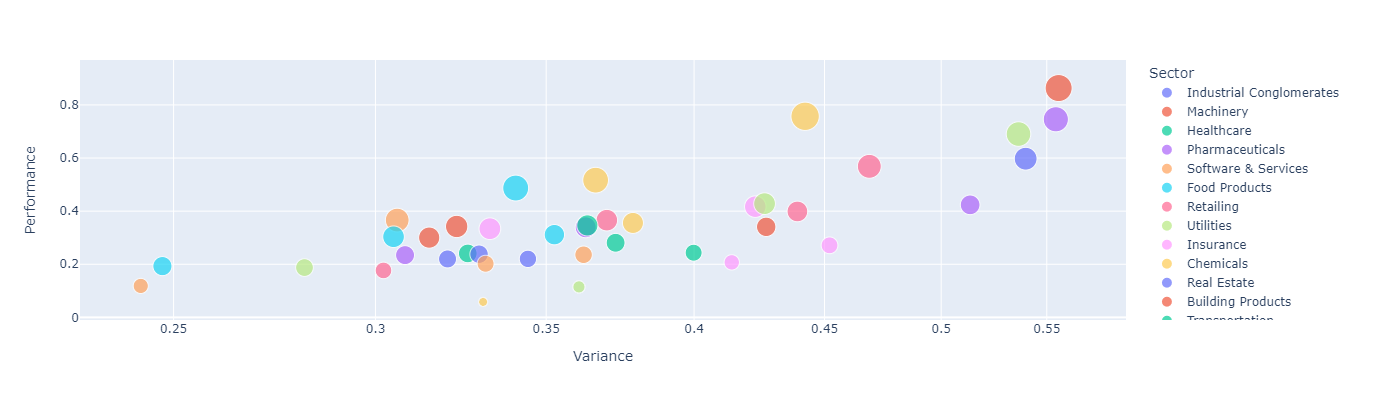

In [289]:
fig = px.scatter(df, x="Variance", y="Performance",
	         size="Sharpe Ratio", color="Sector",
                 hover_name="Sector", log_x=True,width=800, height=400)

fig.show()

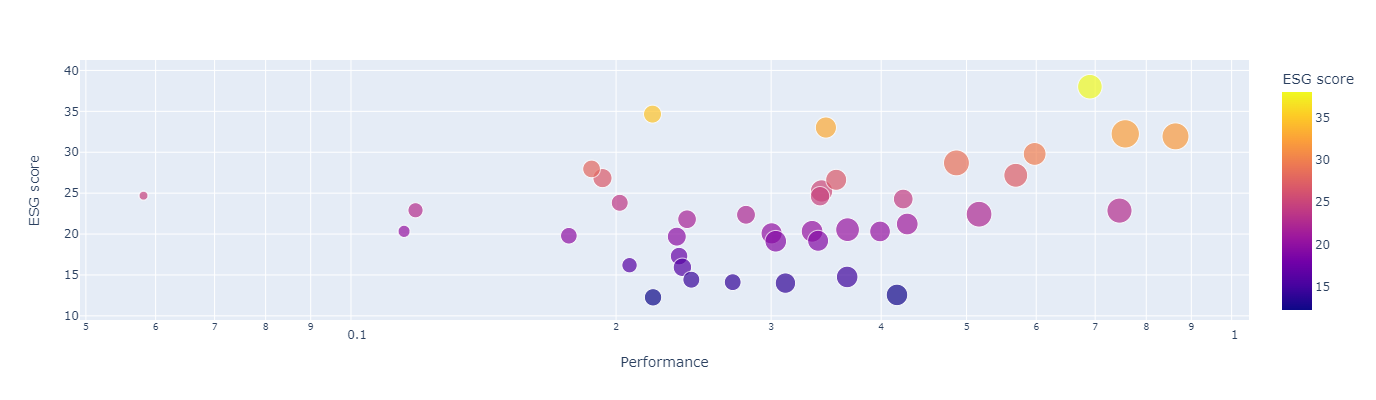

In [290]:
fig = px.scatter(df, x="Performance", y="ESG score",
	         size="Sharpe Ratio", color="ESG score",
                 hover_name="Sector", log_x=True,width=800, height=400)

fig.show()

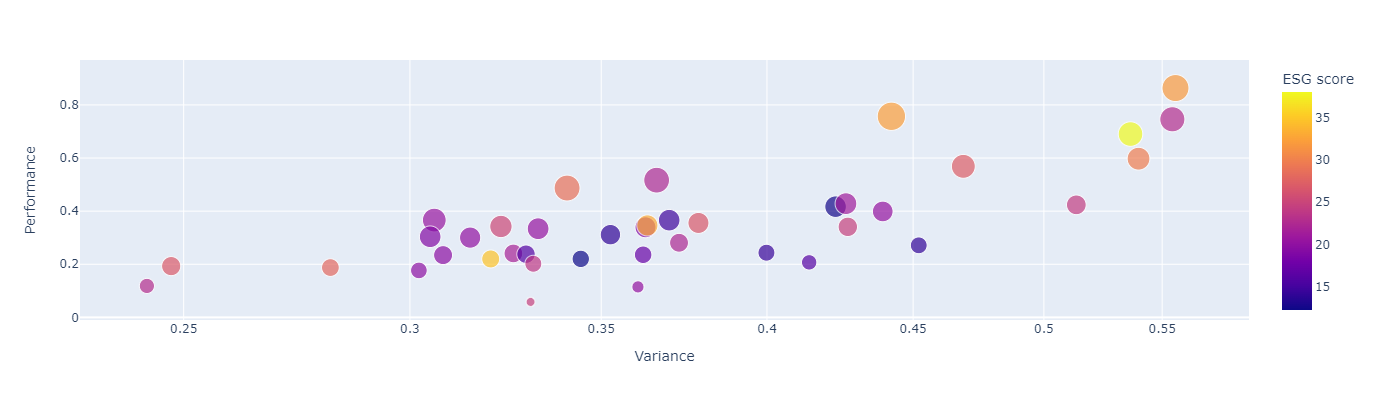

In [291]:
fig = px.scatter(df, x="Variance", y="Performance",
	         size="Sharpe Ratio", color="ESG score",
                 hover_name="Sector", log_x=True,width=800, height=400)

fig.show()

In [292]:
stock_characteristics={}

for stock in esg['Stock'].unique():
    var=returns[stock].std()*252**0.5
    mean=returns[stock].mean()*252
    sharpe_ratio=mean/var
    sector=esg[esg['Stock']==stock]['Sector'].values[0]
    score=esg[esg['Stock']==stock]['ESG score'].values[0]
    stock_characteristics[stock]=(mean,var,sharpe_ratio,score,sector)

stock_data=pd.DataFrame.from_dict(stock_characteristics)
stock_data=stock_data.T.reset_index()
stock_data=stock_data.rename(columns={'index':'Stock',0:'Performance',1:'Variance',2:'Sharpe Ratio',3:'ESG score',4:'Sector'})

In [293]:
sorted_stock=stock_data.sort_values('ESG score')

sorted_stock[['Performance','Variance','Sharpe Ratio','ESG score']]=sorted_stock[['Performance','Variance','Sharpe Ratio','ESG score']].astype(float)
sorted_stock['Sector']=sorted_stock['Sector'].astype(str)

In [294]:
best_50_stocks=sorted_stock[:50]
worst_50_stocks=sorted_stock[len(sorted_stock)-50:]

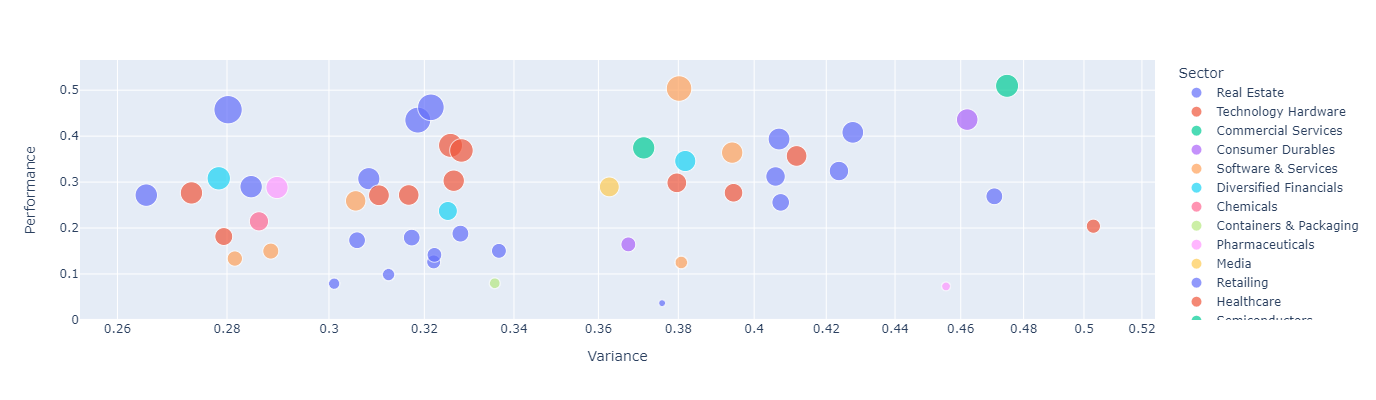

In [295]:
fig2 = px.scatter(best_50_stocks, x="Variance", y="Performance",
	         size="Sharpe Ratio", color="Sector",color_continuous_scale='viridis',
                 hover_name="Stock", log_x=True,width=800, height=400)
fig2.show()


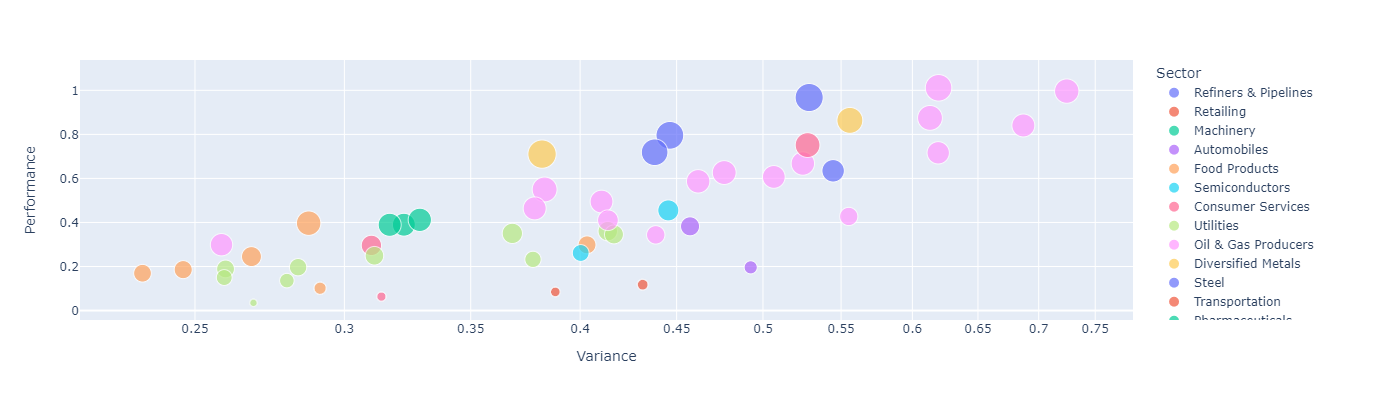

In [296]:
fig2 = px.scatter(worst_50_stocks, x="Variance", y="Performance",
	         size="Sharpe Ratio", color="Sector",color_continuous_scale='magma',
                 hover_name="Stock", log_x=True,width=800, height=400)

fig2.show()

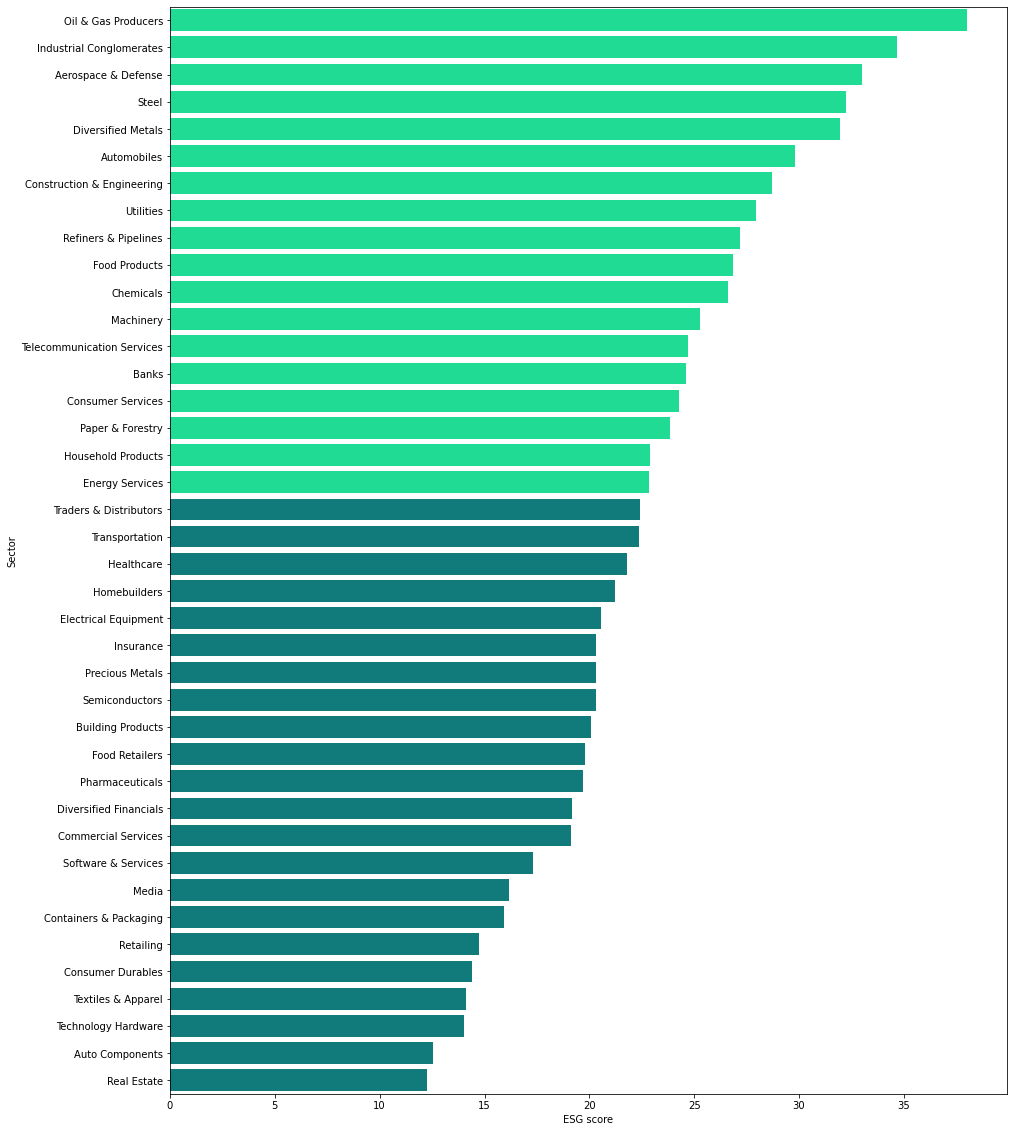

In [297]:
esg_data.plot_sectors()

## Portfolio simulation and performance comparison

In [298]:
best50=best[:50]
worst50=worst[len(worst)-50:]

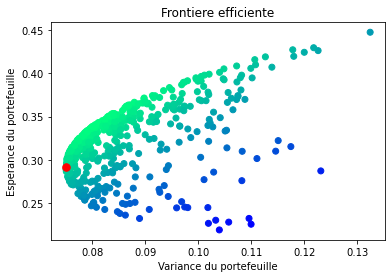

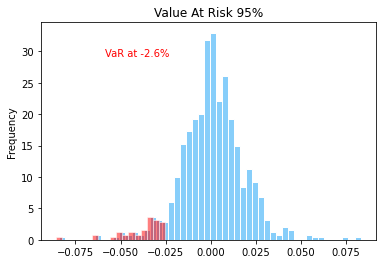

In [299]:
best_random=Randomize(best,3).random_assets()
portfolio=Portfolio(returns[best_random])
portfolio.plot_portfolio('winter')
portfolio.plot_VaR()

In [300]:
range_assets=[n for n in range(0,10,5)]
range_assets[0]=1
range_assets

[1, 5]

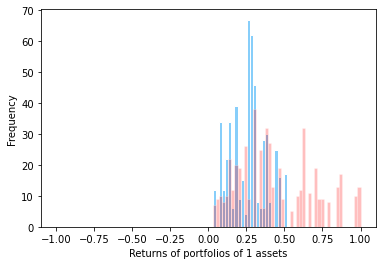

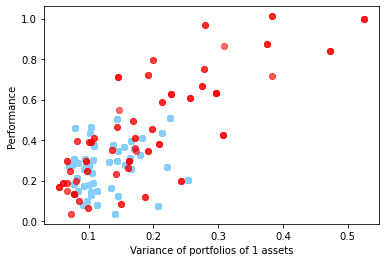

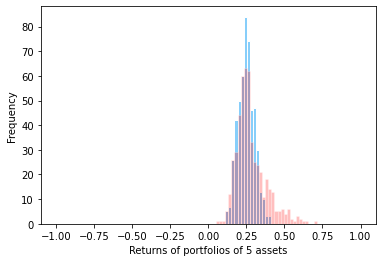

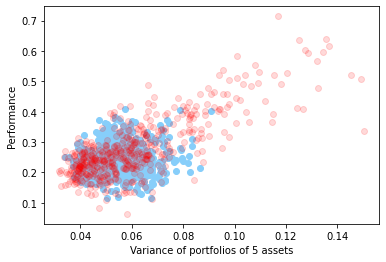

In [301]:
best_esg={}
worst_esg={}

for n in range_assets:

    best_performance=[]
    worst_performance=[]
    best_variance=[]
    worst_variance=[]
    best_VaR=[]
    worst_VaR=[]
    
    for i in range(500):
        best_random=Randomize(best50,n).random_assets()
        worst_random=Randomize(worst50,n).random_assets()

        best_portfolio=Portfolio(returns[best_random])
        worst_portfolio=Portfolio(returns[worst_random])
        best_perf=best_portfolio.performance(best_portfolio.optimize())
        worst_perf=worst_portfolio.performance(worst_portfolio.optimize())
        best_var=best_portfolio.variance(best_portfolio.optimize())
        worst_var=worst_portfolio.variance(worst_portfolio.optimize())
        best_Value_at_risk=best_portfolio.VaR()
        worst_Value_at_risk=worst_portfolio.VaR()
        
        best_VaR.append(best_Value_at_risk)
        worst_VaR.append(worst_Value_at_risk)
        
        best_performance.append(best_perf)
        worst_performance.append(worst_perf)
        best_variance.append(best_var)
        worst_variance.append(worst_var)
        
        worst_esg[n]=(np.mean(worst_performance),np.mean(worst_variance),np.mean(worst_VaR))
        best_esg[n]=(np.mean(best_performance),np.mean(best_variance),np.mean(best_VaR))
        
    bins=np.linspace(-1, 1, 100)
    plt.hist(best_performance,bins,alpha=1,color='lightskyblue',edgecolor='white')
    plt.hist(worst_performance,bins,alpha=0.25,color='red',edgecolor='white')
    plt.xlabel('Returns of portfolios of '+str(n)+' assets')
    plt.ylabel('Frequency')
    plt.show()

    plt.scatter(best_variance,best_performance,color='lightskyblue')
    plt.scatter(worst_variance,worst_performance,alpha=0.15,color='red')
    plt.ylabel('Performance')
    plt.xlabel('Variance of portfolios of '+str(n)+' assets')
    plt.show()

In [302]:
best_esg

{1: (0.2635666128929652, 0.12504116258166834, -0.031889987910770905),
 5: (0.24831945490188592, 0.056135415750987204, -0.02198044789588407)}

In [303]:
worst_esg

{1: (0.4503607632683987, 0.19308866401452196, -0.03781182721143821),
 5: (0.2777743323454347, 0.06089467337960745, -0.022448969664163373)}

# Portfolio creation

## Benchmark creation

In [304]:
benchmark=returns[best50['Stock']][1:]
n=len(best50['Stock'])
weight=np.array([1/n]*n)
benchmark['Benchmark']=(benchmark*weight).sum(axis=1)

In [386]:
best50['Sector'].unique()
Sectors=esg_data.sectors()

## Stock picking

<AxesSubplot:>

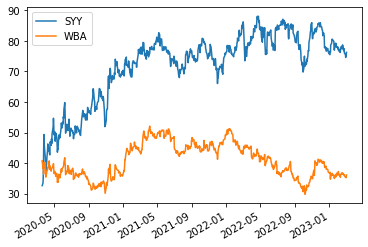

In [307]:
stock_price[['SYY','WBA']].plot()

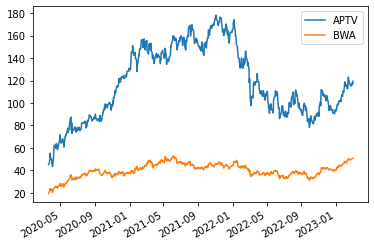

In [308]:
stock_price[['APTV','BWA']].plot()
autocomponents_stock=['APTV','BWA']

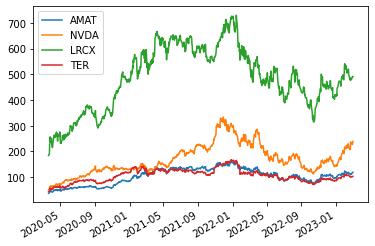

In [309]:
stock_price[['AMAT','NVDA','LRCX','TER']].plot()
semiconductors_stock=['NVDA']

<AxesSubplot:>

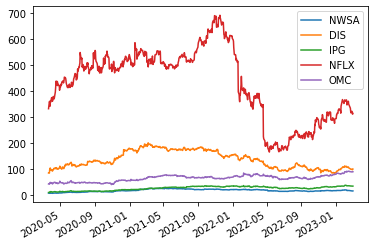

In [310]:
stock_price[['NWSA','DIS','IPG','NFLX','OMC']].plot()

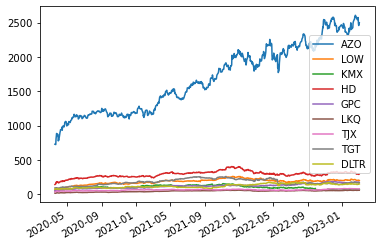

In [311]:
stock_price[['AZO','LOW','KMX','HD','GPC','LKQ','TJX','TGT','DLTR']].plot()
Retail_stock=['AZO','GPC']

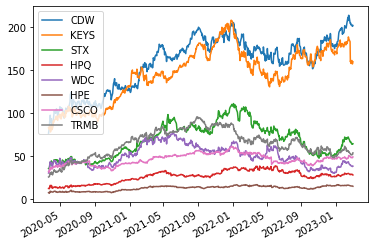

In [312]:
stock_price[['CDW','KEYS','STX','HPQ','WDC','HPE','CSCO','TRMB']].plot()
Technology_stock=['CDW']

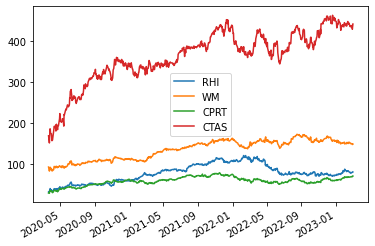

In [313]:
stock_price[['RHI','WM','CPRT','CTAS']].plot()
Commercial_stock=['CPRT']

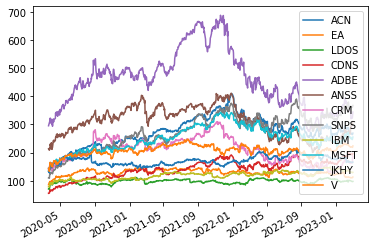

In [361]:
stock_price[['ACN','EA','LDOS','CDNS','ADBE','ANSS','CRM','SNPS','IBM','MSFT','JKHY','V']].plot()
Software_stock=['CDNS' ,'ANSS','CRM','MSFT','NOW']

In [362]:
Selected_stock=[]
Selected_stock.append(Software_stock)
Selected_stock.append(Commercial_stock)
Selected_stock.append(Technology_stock)
Selected_stock.append(Retail_stock)
Selected_stock.append(semiconductors_stock)
Selected_stock.append(autocomponents_stock)

In [535]:
stocks=[]
for i in range(len(Selected_stock)):
    for stock in Selected_stock[i]:
        stocks.append(stock)
    

## Data cleaning

In [380]:
SP500=pd.read_excel(r'C:\Users\niroo\Desktop\Jupyter\Projets\Ethique\S&P500-2023.xlsx',index_col=0)

In [383]:
stock_price2023=SP500[:-1]
stock_price2023=stock_price2023.dropna(axis='columns')
returns2023=stock_price2023.pct_change()

## Benchmark creation

In [452]:
portfolio=returns2023[stocks]
benchmark=returns2023[best50['Stock']][1:]
n=len(best50['Stock'])
weight=np.array([1/n]*n)
benchmark['Benchmark']=(benchmark*weight).sum(axis=1)

## Portfolio optimization

In [450]:
weights=Portfolio(portfolio).optimize()
portfolio_performance=pd.DataFrame()
portfolio_performance['Portfolio']=(portfolio*weights).sum(axis=1)
portfolio_performance['Benchmark']=benchmark['Benchmark']
portfolio_performance['Tracking Error']=portfolio_performance['Portfolio']-portfolio_performance['Benchmark']

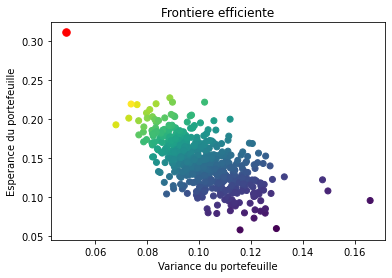

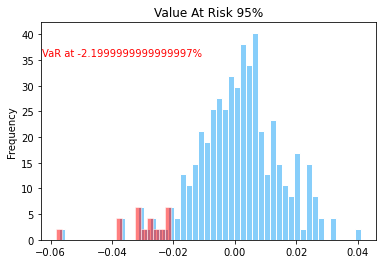

-0.021681206250351363

In [503]:
Portfolio(portfolio).plot_portfolio()
Portfolio(portfolio).plot_VaR()
Portfolio(portfolio).VaR()

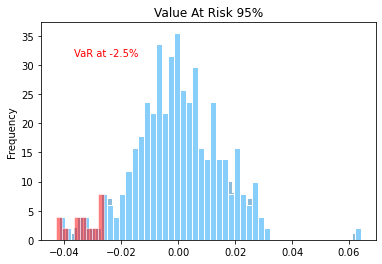

In [498]:
plt.hist(portfolio_performance['Benchmark'],bins=40,alpha=0.5,)
VaR=np.percentile(portfolio_performance['Benchmark'][1:],5,interpolation='lower')
hist, bins, _ = plt.hist(portfolio_performance['Benchmark'], bins=50, density=True,color='lightskyblue',edgecolor='white')
mask = (bins[:-1] < VaR)
for i in range(len(mask)):
    if mask[i]:
        plt.bar(bins[i], hist[i], width=bins[i+1]-bins[i],alpha=0.5, color='red',edgecolor='white')
plt.text(VaR, max(hist)*0.9, 'VaR at '+str(round(VaR,3)*100) +'%', ha='center', va='center', color='r', fontsize=10)
plt.ylabel('Frequency')
plt.title('Value At Risk 95%')
plt.show()

## Performance comparison

In [424]:
portfolio_performance.mean()*252

Portfolio         0.310077
Benchmark        -0.068562
Tracking Error    0.379936
dtype: float64

## Variance comparison

In [425]:
portfolio_performance.std()*252**0.5

Portfolio         0.220116
Benchmark         0.237674
Tracking Error    0.144356
dtype: float64

## Sharpe Ratio comparison

In [426]:
portfolio_performance.mean()*252/(portfolio_performance.std()*252**0.5)

Portfolio         1.408702
Benchmark        -0.288470
Tracking Error    2.631942
dtype: float64

In [538]:
esg=esg.drop_duplicates()

In [542]:
(esg.set_index('Stock').T[stocks][1:]*weights).sum(axis=1)

ESG score    12.64267
dtype: float64

In [543]:
np.dot(esg.set_index('Stock').T[stocks][1:],weights.reshape(12,1))

array([[12.64267018757453]], dtype=object)